In [4]:
import numpy as np
import cv2
import os
from roipoly import roipoly
import sys
from numpy.linalg import inv, det
import math
import matplotlib.pyplot as plt


def gaussian_d(mean,conv,px):
    '''Takes the mean, conv, and input to output a probability value'''

    exponent = -0.5*(np.dot(np.dot(((px-mean.T)),(inv(conv))),(px-mean)))
    
    denom = (((2*math.pi)**len(mean))*(det(conv)))**(0.5)
    
    return np.exp(exponent) / denom


def area2distance(area):
    '''Use the linear regression model to estimate distance from area'''
    
    # piece-wise model for area > 40000, linear interpolation
    if float(area) > 40000:
        return -(1.75/1040000)*(area-40000) + 1.75
    
    # weights for 3rd order linear regression in distance to weight
    weights = np.array([[  9.84862396e+00],
                         [ -5.62142184e-04],
                         [  1.17923139e-08],
                         [ -7.27030137e-14]])
    
    # 3rd order linear regression
    x = area
    d_est = weights[0] + weights[1]*x + weights[2]*(x**2) + weights[3]*(x**3)
    
    return d_est


def myAlgorithm(img):
    
    # parameters for the single gaussian classes red and non-red
    
    red_mean = np.array([  81.87621432,  189.34238673,  110.84483535])

    red_conv = np.array([[ 1172.25587934,   414.50883425,  -111.10292319],
                           [  414.50883425,   450.53835391,  -119.00027297],
                           [ -111.10292319,  -119.00027297,    45.19610345]])

    non_red_mean = np.array([ 113.47240965,  132.21579128,  121.75763276])

    non_red_conv = np.array([[ 3638.34138158,    12.29202851,   -20.82667596],
                               [   12.29202851,   215.92121636,  -133.80788615],
                               [  -20.82667596,  -133.80788615,   136.20090153]])
    
    # save the input image
    img_save = img.copy()
    
    # for color segmentation
    img_color = img.copy()
    
    # convert image to YCrCb color space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    img = np.asarray(img)  # cast image to array
    
    # get height and width of the image
    IMG_H = img.shape[0]
    IMG_W = img.shape[1]
    
    # convert pixels into 1-d array
    img = img.reshape(IMG_H*IMG_W, 3)
    testset_mask = []
    
    # classify each pixel into red or non-red
    for px in img:
        if gaussian_d(red_mean,red_conv, px) >= gaussian_d(non_red_mean,non_red_conv, px):
            testset_mask.append(True)
        else:
            testset_mask.append(False)
    
    testset_mask = np.asarray(testset_mask).reshape(IMG_H,IMG_W)
    
    # find the contours on the mask
    img, contours, hierarchy = cv2.findContours(testset_mask.astype(np.uint8), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)                    

    # loop thru each contour, find contour with max area and identify it as the barrel
    contour_max = contours[0]  # initialize
    
    for contour in contours:
        if cv2.contourArea(contour) > cv2.contourArea(contour_max):
            contour_max = contour

    # fit a minimum rectangle box on the barrel contour
    box_max = cv2.minAreaRect(contour_max)
    box_area_max = box_max[1][0]*box_max[1][1]

    # find bounding points of the barrel
    barrel_pts_float = cv2.boxPoints(box_max)
    barrel_pts = np.int0(barrel_pts_float)

    # try to identify the top and bottom corners
    barrel_pts_float = sorted(barrel_pts_float, key = lambda x: x[1]) # sorted by y axis
    top_corners = barrel_pts_float[:2]
    bottom_corners = barrel_pts_float[2:]
    
    top_corners = sorted(top_corners, key = lambda x: x[0]) # sorted by x axis
    bottom_corners = sorted(bottom_corners, key = lambda x: x[0]) # sorted by x axis
    
    top_right = top_corners[1]
    bottom_left = bottom_corners[0]


    #barrel_img = np.zeros((IMG_H,IMG_W))
    barrel_img = img_save.copy()
    cv2.drawContours(barrel_img,[barrel_pts],0,(255,0,0),2)
    plt.imshow(barrel_img)
    plt.show()
    
    return bottom_left[0], bottom_left[1], top_right[0], top_right[1], area2distance(box_area_max)

002.JPG


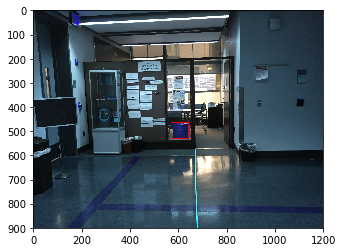

BottomLeftX = 575.999938965, BottomLeftY = 530.0, TopRightX = 643.999938965, TopRightY = 463.0, Distance = [ 7.52540429]

Next Image!
005.png


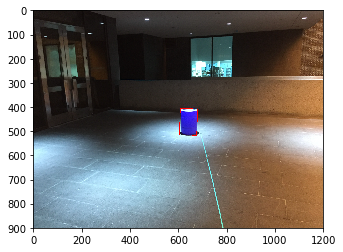

BottomLeftX = 606.568054199, BottomLeftY = 515.571411133, TopRightX = 680.19720459, TopRightY = 408.516296387, Distance = [ 6.17294126]

Next Image!
010.JPG


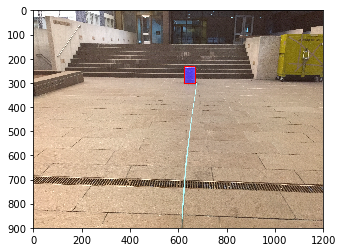

BottomLeftX = 625.0, BottomLeftY = 303.0, TopRightX = 671.0, TopRightY = 234.0, Distance = [ 8.18085896]

Next Image!
003.JPG


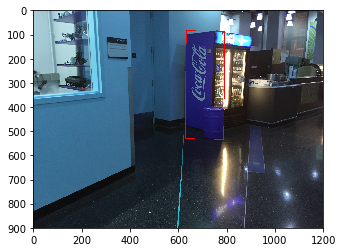

BottomLeftX = 630.046691895, BottomLeftY = 531.963439941, TopRightX = 793.996032715, TopRightY = 87.4259033203, Distance = 1.69735118383

Next Image!
006.JPG


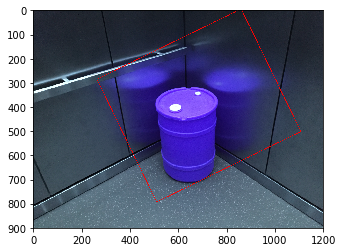

BottomLeftX = 511.180786133, BottomLeftY = 792.371582031, TopRightX = 861.929199219, TopRightY = -5.47900390625, Distance = 1.18671425135

Next Image!
009.JPG


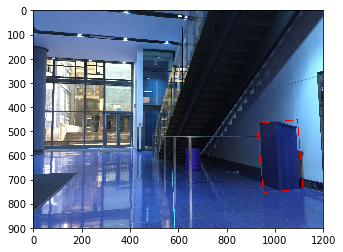

BottomLeftX = 952.471862793, BottomLeftY = 753.354858398, TopRightX = 1094.25708008, TopRightY = 453.536254883, Distance = 1.73717009764

Next Image!
008.JPG


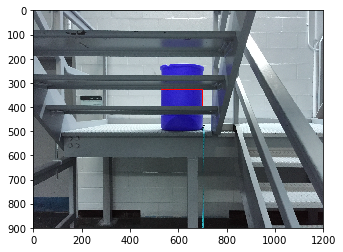

BottomLeftX = 529.0, BottomLeftY = 396.0, TopRightX = 701.0, TopRightY = 329.0, Distance = [ 4.82528117]

Next Image!
007.JPG


KeyboardInterrupt: 

In [7]:
# run my algorithm on testset images 

folder = "testset"

for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, filename))
    
    # resize input images to 900 by 1200
    img = cv2.resize(img, (1200,900))
    
    print filename
    
    blX, blY, trX, trY, d = myAlgorithm(img)
        
    print "BottomLeftX = {a}, BottomLeftY = {b}, TopRightX = {c}, TopRightY = {f}, Distance = {e}".format(a=blX, b=blY, c=trX, f=trY, e=d)
    print ""
    
    # These two lines are commented out because they don't work on my machine
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    print "Next Image!"
